In [1]:
import io
import numpy as np
import scipy
from thoughtcloud import ThoughtCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from ipywidgets import widgets
import cairosvg
from PIL import ImageFilter, Image
from sklearn.preprocessing import normalize
import cProfile
import profile

# Placing concepts

In [43]:
import json
# with open("spaces/embedded_01.json") as f:
with open("spaces/chatgpt.json") as f:
  concepts = json.load(f)

In [44]:
from matplotlib.axes import Axes
from matplotlib.axis import Axis


def plot_concepts(concepts):
  x,y = list(zip(*concepts.values()))
  n=list(concepts.keys())
  fig, ax = plt.subplots()
  ax.scatter(x, y)

  for i, txt in enumerate(n):
      ax.annotate(txt, (x[i], y[i]))
  plt.show()

def plot_concepts_with_dot(concepts, dot):
  x,y = list(zip(*concepts.values()))
  n=list(concepts.keys())
  plt.clf()
  fig, ax  = plt.subplots(1,1)
  ax.scatter(x, y, alpha=0.5)
  for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]), alpha=0.5)
  ax.scatter(*dot, color="red", zorder=10)


  plt.show()



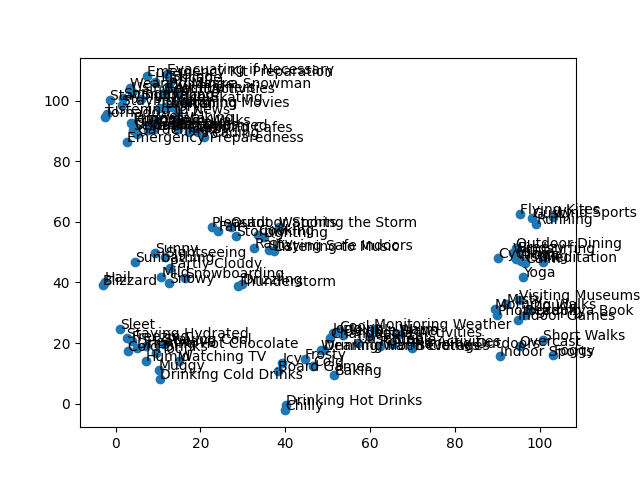

In [45]:
%matplotlib ipympl
plot_concepts(concepts)

# Calculate distances

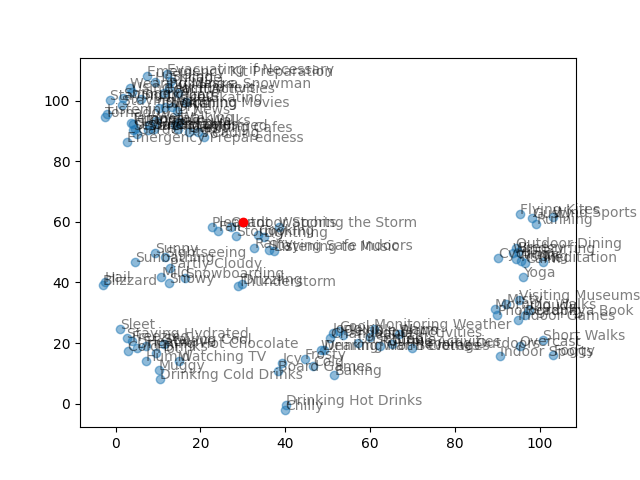

In [46]:
dot = (30,60)
plot_concepts_with_dot(concepts,dot)

(np.float64(40.816326530612244), np.float64(10.204081632653061))


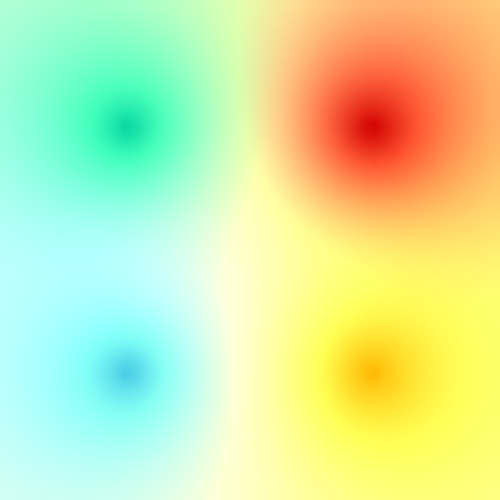

In [23]:

def rgb(hex):
  return np.array(tuple(int(hex[i:i+2], 16) for i in (0, 2, 4)))
colors = {
  "48cae4": (25.001,25.001),
  "ffb703": (75.001,25.001),
  "06d6a0": (25.001,75.001),
  "d00000": (75.001, 75.001)
}

def color_words(word, *args, **kwargs):
  color = dot_color_interpolation(concepts[word])
  return np_color_to_tuple(color)

def np_color_to_tuple(c):
  return tuple(int(i) for i in c)

def dot_color_interpolation(dot):
  c = np.array(list(colors.values()))
  p = np.array([dot])
  if int(dot[0]) == 40 and int(dot[1]) == 10:
    print(dot)
  dist = np.reciprocal(scipy.spatial.distance.cdist(p,c)).clip(0, np.finfo(dtype=np.float64).max)
  dist = normalize(dist ** 1/2,)
  color_value = np.array(list([rgb(i) for i in colors.keys()]))
  return np.matmul(dist,color_value)[0].clip(0,255)

# color_words("Cold")
img = np.array([[dot_color_interpolation((x,y))for x in np.linspace(0,100,50)] for y in np.linspace(0,100,50)][::-1])
Image.fromarray(np.array(img).astype(np.uint8)).resize((500,500))

In [41]:


def get_bg_color(w,h):
  wc =np_color_to_tuple(dot_color_interpolation((w,h)))
  return (255-wc[0],255-wc[1],255-wc[2])
from functools import lru_cache

def get_cloud(
    dot,
    wc_config={
      "background_color":None,
      "mode":"RGBA",
      "max_font_size":90,
      "random_state":0,
      "color_func":color_words,
    },
    mask_path="circle_small.png",
    fg_max_words=15,
    bg_max_words=7,
    fg_config={
      "scale": 4,
    },
    bg_config={
      "height": 60,
      "width": 60,
      "scale": 8,
      "min_font_size": 2,
      "font_step": 8
    }
  ):
  mask = np.array(Image.open(mask_path))
  wordcloud = ThoughtCloud(mask=mask, **fg_config,  **wc_config)
  wordcloud_bg = ThoughtCloud(**bg_config, **wc_config)
  concepts = np.array(list(concepts.values()))
  player = np.array([dot])



  dist = np.reciprocal(scipy.spatial.distance.cdist(player,concepts))



  d=sorted(list(zip(concepts.keys(), np.nan_to_num(dist[0]))), key=lambda x: x[1], reverse=True)
  return (
    wordcloud.generate_from_frequencies(frequencies=dict(d[:fg_max_words])),
    wordcloud_bg.generate_from_frequencies(frequencies=dict(d[:bg_max_words]))
  )

# Playground
Here we have a little demo for development. Even without the cache it's decent, but it's bound to this process.

Separating the word cloud render and the bg render was an interesting choice

In [42]:
@lru_cache(1000)
def get_cloud_images(w, h):
  wc_fg, wc_bg = get_cloud((w,h)) 
  # plot_concepts_with_dot(concepts, (w,h))
  return (wc_fg.to_image(), wc_bg.to_image())


margin = 5
def get_frame(w,h):
  im, im_bg = get_cloud_images(int(w/margin)*margin,int(h/margin)*margin) 
  bg = Image.new('RGBA', im.size, color=get_bg_color(w,h))
  bg.paste(im, (0,0),im)
  bg.paste(im_bg, (0,0),im_bg)
  blurred = bg.filter(ImageFilter.BoxBlur(10)) # Faster than gaussian, and the box look fits
  blurred.paste(im, (0,0),im)
  return blurred

@widgets.interact(readout_format='.3f')
def update(w=(0.0,100.0), h=(0.0,100.0)):
  # plot_concepts_with_dot(concepts, (w,h))
  return get_frame(w,h)


interactive(children=(FloatSlider(value=50.0, description='w'), FloatSlider(value=50.0, description='h'), Outp…

# Exporting and pre-rendering
Python is slow, wordcloud is slow.

On my mac, average frame time (after optimization of my code and the library) is 0,07s, yieding about 15 fps. Some better results can be achieved by rendering background separately and limiting the resolution of the wordcloud (only render every 5, or 10) and adding cache. 

In [9]:
cProfile.run('update(50,50)',sort="cumtime")


         615 function calls in 0.006 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.006    0.006 {built-in method builtins.exec}
        1    0.000    0.000    0.006    0.006 <string>:1(<module>)
        1    0.001    0.001    0.006    0.006 3780666459.py:18(update)
        1    0.000    0.000    0.005    0.005 3780666459.py:9(get_frame)
        1    0.000    0.000    0.003    0.003 Image.py:1294(filter)
        1    0.000    0.000    0.003    0.003 ImageFilter.py:202(filter)
        1    0.003    0.003    0.003    0.003 {method 'box_blur' of 'ImagingCore' objects}
        3    0.000    0.000    0.001    0.000 Image.py:1683(paste)
        3    0.001    0.000    0.001    0.000 {method 'paste' of 'ImagingCore' objects}
        1    0.000    0.000    0.000    0.000 261951177.py:1(get_bg_color)
        1    0.000    0.000    0.000    0.000 2878675775.py:17(dot_color_interpolation)
        1  

## Just save the images
Prerendering to memory takes a whole minute.
Saving them to disk, takes 13 minutes and 1,12GB

They're not options unless we use less wordclouds

In [10]:
#frames = [[get_frame(x,y).save(f"export/%{x}_{y}.png") for x in range(100)] for y in range(100)]

# Partial Baking

Most of the time is spent on fitting fonts on the cloud, a process with correlated time and quality.

What if we pre-fit the words to a format like svg and then export this to another software that just renders images. That way I dont have to worry about re-writing the wordcloud algorithm or figuring out some weird server or IPC schema. Bake where it's easy, render where it's fast, store a minimal representation.

This method generates 10000 images in 7min. The svg's weigh 

In [26]:
resolution = 5

In [33]:
def svg_export(x,y):
  fg, bg = get_cloud((x,y),
    wc_config={
      "background_color":None,
      "mode":"RGBA",
      "max_font_size":90,
      "random_state":0,
      "color_func":color_words,
    },
    mask_path="circle.png",
    fg_max_words=30,
    bg_max_words=15,
    fg_config={
      "scale": 2,
    },
    bg_config={
      "height": 180,
      "width": 180,
      "scale": 8,
      "min_font_size": 2,
      "font_step": 2
    }
    
  )
  with open(f"export/fg_{x}-{y}.svg", "w") as f:
    f.write(fg.to_svg())
  with open(f"export/bg_{x}-{y}.svg", "w") as f:
    f.write(bg.to_svg())

frames = [[svg_export(x,y)for x in range(0,101,resolution)] for y in range(0,101,resolution)]

/var/folders/07/pjgm4z0s72vf2v1vm7q09pz00000gn/T/ipykernel_58099/3518527442.py:22: RuntimeWarning: divide by zero encountered in reciprocal
  dist = np.reciprocal(scipy.spatial.distance.cdist(p,c)).clip(0, np.finfo(dtype=np.float64).max)
/var/folders/07/pjgm4z0s72vf2v1vm7q09pz00000gn/T/ipykernel_58099/3518527442.py:22: RuntimeWarning: divide by zero encountered in reciprocal
  dist = np.reciprocal(scipy.spatial.distance.cdist(p,c)).clip(0, np.finfo(dtype=np.float64).max)
/var/folders/07/pjgm4z0s72vf2v1vm7q09pz00000gn/T/ipykernel_58099/3518527442.py:22: RuntimeWarning: divide by zero encountered in reciprocal
  dist = np.reciprocal(scipy.spatial.distance.cdist(p,c)).clip(0, np.finfo(dtype=np.float64).max)
/var/folders/07/pjgm4z0s72vf2v1vm7q09pz00000gn/T/ipykernel_58099/3518527442.py:22: RuntimeWarning: divide by zero encountered in reciprocal
  dist = np.reciprocal(scipy.spatial.distance.cdist(p,c)).clip(0, np.finfo(dtype=np.float64).max)
/var/folders/07/pjgm4z0s72vf2v1vm7q09pz00000gn/T

In [34]:

from wand.api import library
import wand.color
import wand.image

# @lru_cache(1000)
# def get_cloud_images(x, y):
#   with open(f"export/fg_{x}-{y}.svg", "r") as f:
#     fg = Image.open(io.BytesIO(cairosvg.svg2png(f.read())))
#   with open(f"export/bg_{x}-{y}.svg", "r") as f:
#     bg = Image.open(io.BytesIO(cairosvg.svg2png(f.read())))

#   return (fg,bg)

size = 360

@lru_cache(10000)
def get_cloud_images(x, y):
  # with open(f"export/fg_{x}-{y}.svg", "rb") as f:
  #   with wand.image.Image() as image:
  #     with wand.color.Color('transparent') as background_color:
  #         library.MagickSetBackgroundColor(image.wand, 
  #                                         background_color.resource) 
  #     image.read(blob=f.read(), format="svg")
  #     png_image = image.make_blob("png32")
  #     fg = Image.open(io.BytesIO(png_image))

  # with open(f"export/bg_{x}-{y}.svg", "rb") as f:
  #   with wand.image.Image() as image:
  #     with wand.color.Color('transparent') as background_color:
  #         library.MagickSetBackgroundColor(image.wand, 
  #                                         background_color.resource) 
  #     image.read(blob=f.read(), format="svg")
  #     png_image = image.make_blob("png32")
  #     bg = Image.open(io.BytesIO(png_image))
  with open(f"export/fg_{x}-{y}.svg", "r") as f:
    fg = Image.open(io.BytesIO(
      cairosvg.svg2png(f.read(), output_width=size, output_height=size)
      ))
  with open(f"export/bg_{x}-{y}.svg", "r") as f:
    bg = Image.open(io.BytesIO(cairosvg.svg2png(f.read(), output_width=size, output_height=size)))

  return (fg,bg)

def get_frame(x,y):
  im, im_bg = get_cloud_images(int(x/resolution)*resolution,int(y/resolution)*resolution) 
  bg = Image.new('RGBA', im.size, color=get_bg_color(x,y))
  bg.paste(im, (0,0),im)
  bg.paste(im_bg, (0,0),im_bg)
  blurred = bg.filter(ImageFilter.BoxBlur(30)) # Faster than gaussian, and the box look fits
  blurred.paste(im, (0,0),im)
  return blurred

@widgets.interact(readout_format='.3f')
def update(x=(0.0,100.0), y=(0.0,100.0)):
  # plot_concepts_with_dot(concepts, (w,h))
  return get_frame(x,y)
# cProfile.run('update(50,60)',sort="cumtime")

interactive(children=(FloatSlider(value=50.0, description='x'), FloatSlider(value=50.0, description='y'), Outp…

In [14]:
# warm cache
#[[get_cloud_images(x,y)for x in range(0,101,resolution)] for y in range(0,101,resolution)]